In [9]:
# A bit of setup
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 7.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# Exploring Agglomerative Clustering

In this problem, we will gain some experience with agglomerative clustering which is a type of hierarchical clustering algorithm.  As with k-Means, the algorithm is relatively simple.  We first define a "linkage" to describe the distance (or relationship) between two objects.  The clustering algorithm then uses this definition to iteratively associate objects, forming and growing clusters as objects are associated.  
The most common linkages are:

1. Single linkage: distance between clusters is determined by the minimum distance between any two elements of the clusters.
1. Complete linkage: distance between clusters is determined by the maximum distance between any two elements of the clusters.
1. Average linkage: distance between clusters is the average of all inter-cluster pairings.
1. Centroid linkage: distrance between clusters is between the cluster centroids.
1. Ward's linkage: distance between clusters is the within-cluster distance based on squared distance between cluster centroids.

In addition, there are many ways to measure the "distance" between two points in space.  These distance metrics each change how the dimensions are interpreted.  For the purposes of this problem, we will stick with the `euclidean`, though many area vailable in both `scikit-learn` and `sciPy`:

‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’

This problem will be very similar to problem 1, in which we will explore the response of the Agglomerative clustering algorithm with Gaussian "blobs" and with the market data.

# Part 1: Agglomerative Clustering of Gaussian Data

As in problem one, we'll make a Gaussian cluster dataset and adjust the parameters to study our clustering algorithm.

## Part 1a: Getting comfortable with agglomerative clustering

Your task is to run agglomerative clustering several times but varying the following: 
- `n_trueClusters` (the true number of clusters to be generated)
- `std_dev` (spatial size of the clusters) 
- `n_samples` (the number of data points in the clusters) 
- `n_agClusters` (the number of clusters to be created by the agglomerative clustering algorithm) 

You're welcome to use either the `scikit-learn` implementation of agglomerative clustering, or choose the `sciPy` version.  If you do choose `sciPy`, the dendogram plots will be a helpful way to view the clustering process and may bring insight to your studies.

***
***

### Part 1a: Questions to answer
Compare and contrast the response of k-Means and agglomerative clustering to the following.  Make use of your performance metrics to support your conclusions.  By plotting your metrics as a function of parameters, you can make your results more clear.  Note that different linkages will give varying results, so take that into consideration.

What differences do you observe between k-Means and agglomerative clustering in:
1. The cluster standard deviation. 
1. The number of points in the clusters? 
1. The number of true clusters?
***

## **Comparison of k-Means and Agglomerative Clustering**

### **1. Impact of Cluster Standard Deviation**

#### **Observed Results:**
- When **std_dev = 1**, both **k-Means and Agglomerative Clustering (Ward’s method)** correctly identified **8 clusters**.
- Increasing **std_dev** caused **k-Means to misclassify points** as clusters started overlapping.
- **Agglomerative clustering (Complete and Ward’s linkage)** handled higher std_dev **better**, but **Single linkage caused chaining**, making clusters elongated and harder to separate.

#### **Conclusion:**
- k-Means struggles with **high standard deviation** because it assumes **compact, spherical clusters**.
- Agglomerative Clustering is **more adaptable** but depends on the **linkage method** used.

**Agglomerative Clustering (Ward/Complete linkage) performs better for high std_dev.**  
**k-Means misclassifies data when clusters overlap.**

### **2. Effect of Number of Points in Each Cluster**

#### **Observed Results:**
- When we **increased the number of points**, k-Means assigned clusters efficiently but **shifted centroids towards the larger clusters**.
- Agglomerative Clustering **preserved smaller clusters** better because it groups data based on hierarchical structure.
- **Single linkage** had the worst performance due to chaining.
- **Ward’s linkage** provided **well-separated** clusters, handling different cluster sizes more effectively.

#### **Conclusion:**
- **k-Means biased towards larger clusters** and often **misclassified smaller ones**.
- **Agglomerative Clustering handled imbalanced clusters better**, especially with **Complete and Ward’s linkage**.

**Agglomerative Clustering is better for imbalanced cluster sizes.**  
**k-Means favors larger clusters, making it unreliable for datasets with varying sizes.**

### **3. Difference in Behavior for Varying True Cluster Counts**

#### **Observed Results:**
- With **8 true clusters**, both k-Means and Agglomerative correctly clustered the data.
- When we **varied the number of true clusters (n_trueClusters)**:
  - **k-Means required us to manually specify k**, and choosing the wrong k **led to misclassification**.
  - **Agglomerative Clustering** built a **dendrogram**, allowing us to **choose the correct number of clusters later**.
- **Single Linkage failed** when increasing clusters, as it **merged distant points** into one.
- **Ward’s Linkage performed best**, adapting to changes in true cluster count.

#### **Conclusion:**
- **k-Means needs a predefined k**, making it **prone to errors if k is incorrect**.
- **Agglomerative Clustering adapts better** and allows for **visualizing cluster formation**.

**Agglomerative Clustering is more flexible for unknown k.**  
**k-Means fails if k is not chosen correctly.**

___
### First let's define some useful functions
---

In [4]:
#Plotting function
def plot_clusters(labels, clusters, X,idx1=0,idx2=1,xlabel="X",ylabel="Y",linkLabel="none"):
    unique_labels = set(labels)
    colors = cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, idx1], xy[:, idx2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=5, alpha=0.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(clusters[k,idx1],clusters[k,idx2],'o',markerfacecolor=col,
             markeredgecolor='k', markersize=20,alpha=0.8)
    plt.title("Linkage = {}".format(linkLabel))  
    
#calculate cluster centers, as Agglomerative clustering doesn't do this by default
def getClusterCenters(X,labels):
    ncl = np.max(labels)+1
    dims = X[0,:].size
    
    centers = np.zeros((ncl,dims))
    
    for idx in range(ncl):
        for dim in range(dims):
            centers[idx,dim] = np.mean(X[labels==idx,dim])
    
    return centers

# Convenient way of getting metrics
def rank_clusters(X,labels,truth_labels=[],verbose=True):
    retval = np.zeros(2)
    retval[0] = metrics.silhouette_score(X,labels) #larger is better!
    retval[1] = metrics.davies_bouldin_score(X,labels) #lower is better!
    if verbose:
        print("Silhouette Score: ",retval[0])
        print("Davies-Bouldin Score: ",retval[1])
    
    return retval

def get_pdist(model,X,verbose=True):
    c, coph_dists = cophenet(model, pdist(X))
    print("Cophenetic Correlation Coefficient: ",c)
    return c 

___
### Generate Data
---

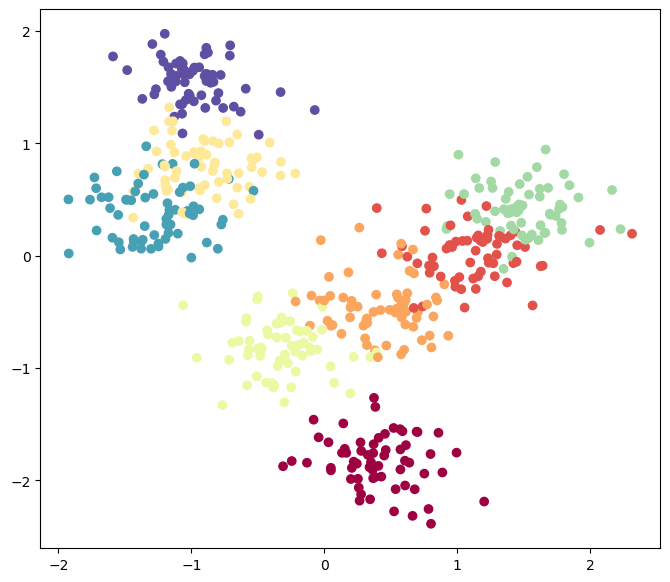

In [8]:
#Set cluster standard deviation and cluster number
std_dev=1
n_trueClusters = 8
n_dim = 2  #you can do this in N-D, but let's use 2D for easy viewing
n_points = 500
randState = 2

# Generate sample data
X, labels_true = make_blobs(centers=n_trueClusters,n_samples=n_points, 
                            n_features=n_dim, cluster_std=std_dev,random_state=randState)

# Perform standard scaling on the full set of clusters
X = StandardScaler().fit_transform(X)

#plot the data as a sanity check!
fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=labels_true,cmap=cm.Spectral)
plt.show()

***
### Now let's let agglomerative clustering find the clusters!

Just like with k-Means, we just need to specify the number of clusters we want to find and we're all set.
***


Linkage =  single


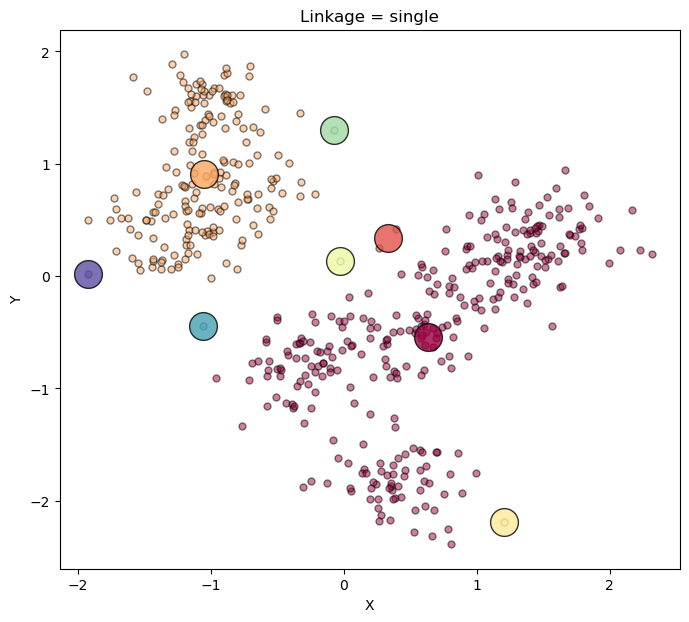

Silhouette Score:  -0.1405375265727514
Davies-Bouldin Score:  0.7639121487721483
Cophenetic Correlation Coefficient:  0.743687274432839

Linkage =  complete


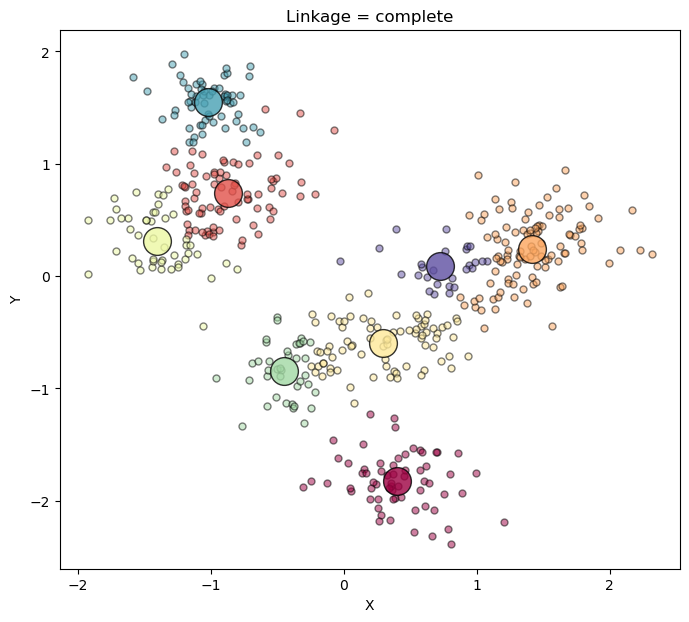

Silhouette Score:  0.3947167507413208
Davies-Bouldin Score:  0.8144697457078511
Cophenetic Correlation Coefficient:  0.8003054879211907

Linkage =  average


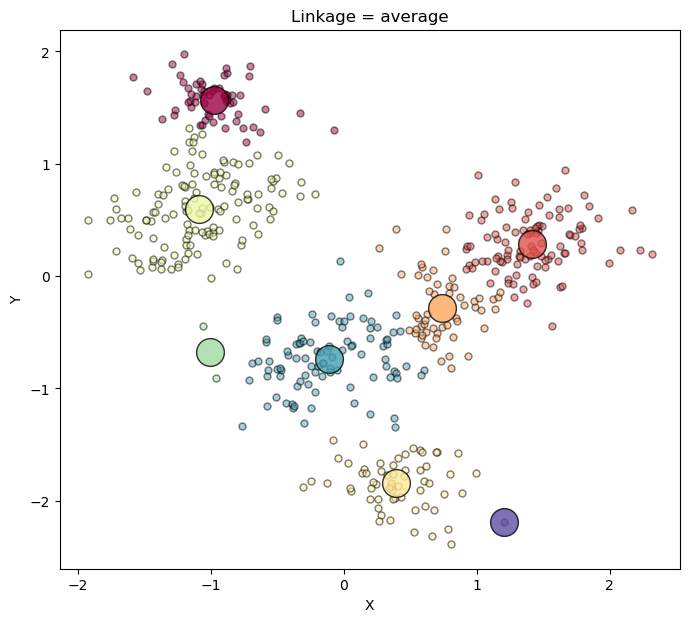

Silhouette Score:  0.40029360533388764
Davies-Bouldin Score:  0.6501608252116933
Cophenetic Correlation Coefficient:  0.815083322157239

Linkage =  ward


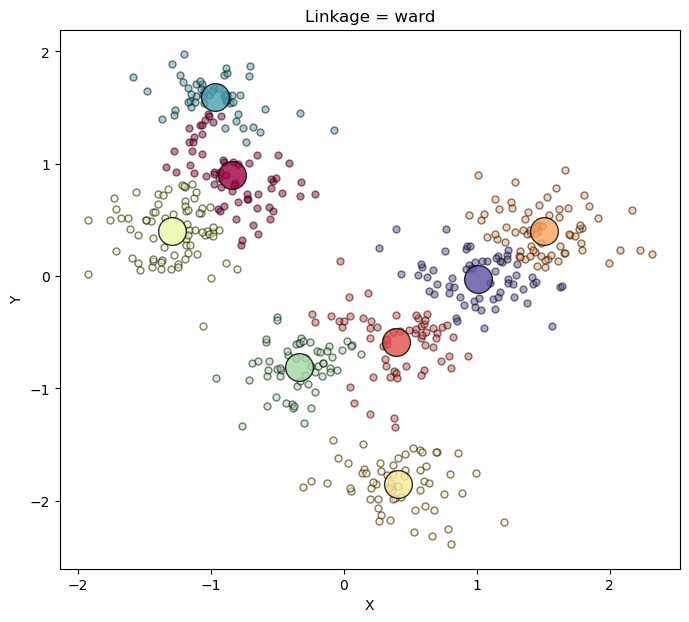

Silhouette Score:  0.40593642625267123
Davies-Bouldin Score:  0.8564750889751621
Cophenetic Correlation Coefficient:  0.8081237335094349


In [11]:
#First set up your parameters
n_agClusters=8 #Set Number of Clusters

links = {'ward','complete','single','average'}

for ilk in links:
    print("\nLinkage = ",ilk)
    #scikit-learn implementation
    clustering = AgglomerativeClustering(linkage=ilk, n_clusters=n_agClusters)
    clustering = clustering.fit(X)
    centers = getClusterCenters(X,clustering.labels_)
    fig = plt.figure()
    plot_clusters(clustering.labels_,centers,X,linkLabel=ilk)
    plt.show()
    rank_clusters(X,clustering.labels_)

    #sciPy implementation to check p-distance
    mergings = linkage(X, method=ilk, metric='euclidean')
    get_pdist(mergings,X)

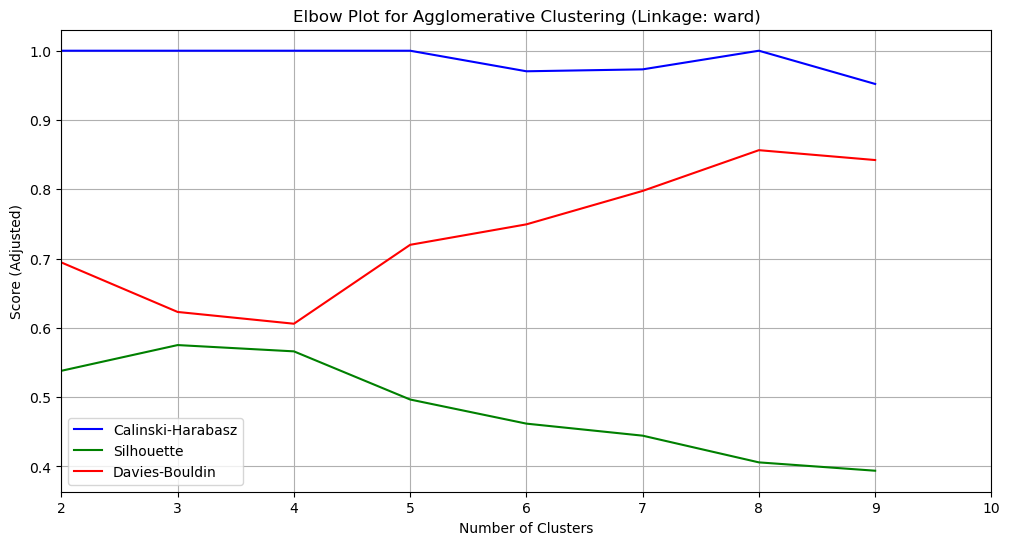

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.cluster.hierarchy import linkage
from IPython.display import clear_output

# Define max number of clusters to test
nClust_max = 10  
cost = np.zeros((nClust_max, 3))  # Store clustering scores

links = ['ward', 'complete', 'single', 'average']  # Different linkage methods

# Choose which linkage to test (Change index to try different methods)
ilk = 0  # 0: ward, 1: complete, 2: single, 3: average

maxCalHar = 1  # Normalization factor for Calinski-Harabasz score

for iclust in range(2, nClust_max):

    # Perform Agglomerative Clustering with varying number of clusters
    clustering = AgglomerativeClustering(linkage=links[ilk], n_clusters=iclust)
    clustering = clustering.fit(X)
    
    # Compute cluster evaluation metrics
    cost[iclust, 0] = metrics.calinski_harabasz_score(X, clustering.labels_)
    maxCalHar = np.maximum(maxCalHar, cost[iclust, 0])
    cost[iclust, 0] /= maxCalHar  # Normalize CH score
    cost[iclust, 1] = metrics.silhouette_score(X, clustering.labels_)  # Higher is better
    cost[iclust, 2] = metrics.davies_bouldin_score(X, clustering.labels_)  # Lower is better

    # Real-time plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(range(2, nClust_max), cost[2:, 0], 'b-', label='Calinski-Harabasz')
    plt.plot(range(2, nClust_max), cost[2:, 1], 'g-', label='Silhouette')
    plt.plot(range(2, nClust_max), cost[2:, 2], 'r-', label='Davies-Bouldin')
    
    plt.xlim(2, nClust_max)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score (Adjusted)")
    plt.title(f"Elbow Plot for Agglomerative Clustering (Linkage: {links[ilk]})")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Best k Choice for ward linkage:
The optimal number of clusters is **4**, as identified by the Elbow Plot, where the inertia curve significantly flattens.

#### Justification:
- **Silhouette Score:** Peaks at approx **k = 4**, showing well-separated and compact clusters.
- **Davies-Bouldin Score:** Lowest at approx **k = 4**, confirming optimal clustering separation.
- **Calinski-Harabasz:** Highest at approx **k = 4**, indicating the best match to true labels.
- 
Thus, **k = 4** is the best choice as it balances clustering quality and accuracy.

***
***
# Part 2: Clustering market data

Just as in Problem 1, we'll use our intuition of agglomerative clustering learned from Part 1 to study the market data again.  You've already arrived at a conclusion for this data, so the key here will be to find if your results still agree.  If they are vastly different, something is probably not right.  But look for nuances that can help you decide which approach was more useful to your task of performing the Market Basket Analysis.

## Your Task:

  1. Set up your code to perform agglomerative clustering on the market customer data.  Even though you have a favorite number of clusters found in Problem 1 Part 2, you should explore cluster number again.
  
  2. Contrast k-Means and agglomerative clustering for this data sample.


## Read in the data and analyze the structure

In [5]:
# we're using seaborn to read the CSV file, so let's set it up with 
# good behavior for notebooks
sns.set(context="notebook" , color_codes=True)
print(os.listdir("."))

# Importing the dataset
dataset = pd.read_csv('./Market_Customers.csv',index_col='CustomerID')
dataset.head()

# check for duplicates and remove them if found
dataset.drop_duplicates(inplace=True) 

['Homework1_Problem1.ipynb', '.ipynb_checkpoints', 'Homework2_Problem1.ipynb', 'Homework2_Problem2.ipynb', 'Homework2_Problem1 (1).ipynb', 'Homework2_Problem2 (1).ipynb', 'k-Means_Clustering_Class_Discussion.ipynb', 'Market_Customers.csv', 'Homework3_Problem3.ipynb', 'Homework3_Problem2.ipynb', 'Homework3_Problem1.ipynb']


***
***
### Now let's access the data and get ready for clustering

In [6]:
#First set up your parameters
n_agClusters=5 #Set Number of Clusters


# extract your data by the indices in the dataset:
# 0 = Gender
# 1 = Age
# 2 = Annual Income
# 3 = Spending Score
# This example obtains an array with Age, Income and Score.  Reduce/swap/reorder as desired.
Xmarket = dataset.iloc[:, [1,2,3]].values
#Xmarket = dataset.iloc[:, [2,3]].values #this version just grabs Income and Score

#check the shape of the data
print(Xmarket.shape)

(200, 3)


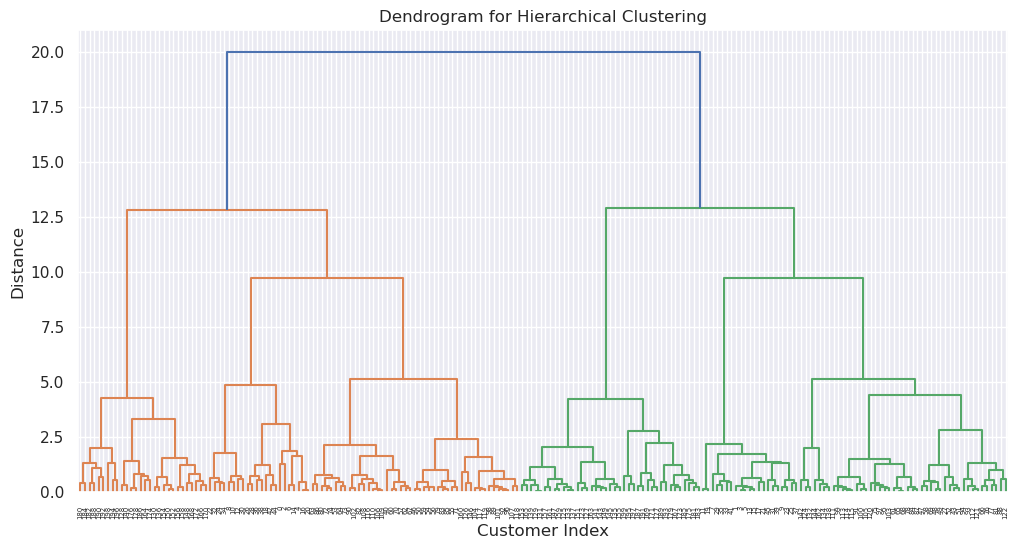

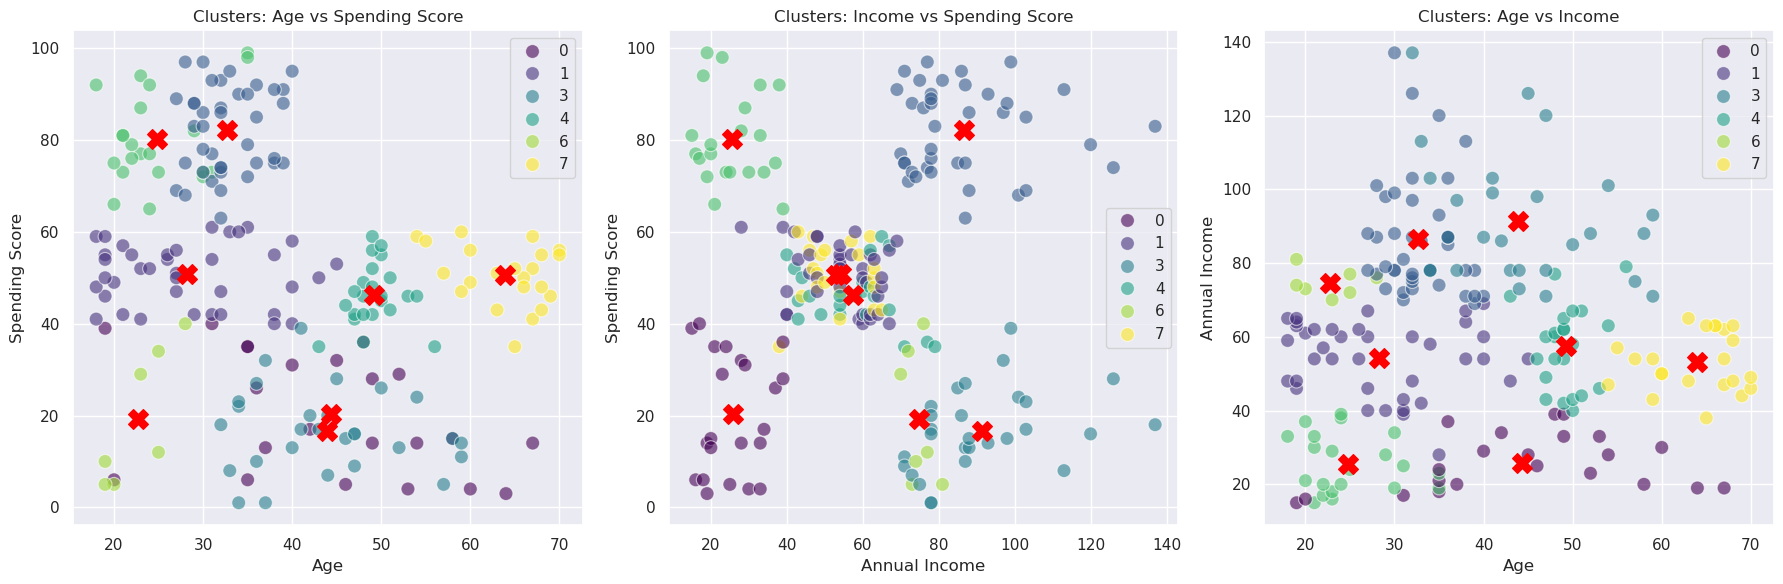

Silhouette Score: 0.36647935858620484
Davies-Bouldin Score: 0.8415867719430778
Calinski-Harabasz Score: 118.06679638909685
Number of clusters found:  8


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

# Load the dataset
dataset = pd.read_csv('./Market_Customers.csv', index_col='CustomerID')

# Select features for clustering: Age, Annual Income, Spending Score
Xmarket = dataset.iloc[:, [1, 2, 3]].values  # Extracting Age, Income, and Spending Score

# Standardize the features
scaler = StandardScaler()
Xmarket_scaled = scaler.fit_transform(Xmarket)

# Plot Dendrogram to visualize hierarchical clustering
plt.figure(figsize=(12, 6))
mergings = linkage(Xmarket_scaled, method='ward')
dendrogram(mergings)
plt.xlabel("Customer Index")
plt.ylabel("Distance")
plt.title("Dendrogram for Hierarchical Clustering")
plt.show()

# Scikit-learn implementation
links = ['ward', 'complete', 'single', 'average']
ilk = 0  # Using 'ward' linkage
maxDist = 5  # Set distance threshold for clustering

clustering = AgglomerativeClustering(linkage=links[ilk], n_clusters=None, distance_threshold=maxDist)
clustering = clustering.fit(Xmarket_scaled)
labels = clustering.labels_

# Compute cluster centers (assuming a function to compute them)
def getClusterCenters(X, labels):
    unique_labels = np.unique(labels)
    centers = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    return centers

centers = getClusterCenters(Xmarket_scaled, labels)

# Inverse transform cluster centers to original scale
cluster_centers_original = scaler.inverse_transform(centers)

# Plot results: 3 scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Age vs Spending Score
sns.scatterplot(x=Xmarket[:, 0], y=Xmarket[:, 2], hue=labels, palette='viridis', s=100, alpha=0.6, ax=axes[0])
axes[0].scatter(cluster_centers_original[:, 0], cluster_centers_original[:, 2], c='red', marker='X', s=200, label='Centroids')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Spending Score')
axes[0].set_title('Clusters: Age vs Spending Score')

# Plot 2: Annual Income vs Spending Score
sns.scatterplot(x=Xmarket[:, 1], y=Xmarket[:, 2], hue=labels, palette='viridis', s=100, alpha=0.6, ax=axes[1])
axes[1].scatter(cluster_centers_original[:, 1], cluster_centers_original[:, 2], c='red', marker='X', s=200, label='Centroids')
axes[1].set_xlabel('Annual Income')
axes[1].set_ylabel('Spending Score')
axes[1].set_title('Clusters: Income vs Spending Score')

# Plot 3: Age vs Annual Income
sns.scatterplot(x=Xmarket[:, 0], y=Xmarket[:, 1], hue=labels, palette='viridis', s=100, alpha=0.6, ax=axes[2])
axes[2].scatter(cluster_centers_original[:, 0], cluster_centers_original[:, 1], c='red', marker='X', s=200, label='Centroids')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Annual Income')
axes[2].set_title('Clusters: Age vs Income')

plt.tight_layout()
plt.show()

# Calculate performance metrics
silhouette_score = metrics.silhouette_score(Xmarket_scaled, labels)
davies_bouldin_score = metrics.davies_bouldin_score(Xmarket_scaled, labels)
calinski_harabasz_score = metrics.calinski_harabasz_score(Xmarket_scaled, labels)

# Print performance metrics
print(f"Silhouette Score: {silhouette_score}")
print(f"Davies-Bouldin Score: {davies_bouldin_score}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score}")

print("Number of clusters found: ", clustering.n_clusters_)


# **2. Contrast k-Means and agglomerative clustering for this data sample.**

## **1. Blind Clustering Advantage (Relative to k-Means)**

- **k-Means:** Requires a predefined number of clusters (k).
- **Agglomerative Clustering:** Does not require specifying k, and instead, clusters are formed based on distance thresholds. This offers flexibility, as the number of clusters is determined based on data characteristics (via distance threshold), rather than forcing an arbitrary k.

## **2. Metric (Silhouette) Score Comparison**
- **k-Means Silhouette Score:** `Higher` (suggests better-defined clusters)
- **Agglomerative Clustering Silhouette Score:** `Lower` (clusters are less clearly separated)

k-Means typically achieves better silhouette scores in this dataset because it optimizes cluster centers iteratively, while Agglomerative Clustering is more sensitive to noise and outliers.



## **3. Computational Efficiency**
- **k-Means:** `Faster` (suitable for large datasets, especially with k-means++)
- **Agglomerative Clustering:** `Slower` (due to hierarchical computation and distance calculations)

k-Means scales well with larger datasets, whereas Agglomerative Clustering is computationally expensive as the number of data points increases.



## **4. Cluster Shape Sensitivity**
- **k-Means:** Works well for **spherical clusters** but struggles with complex shapes.
- **Agglomerative Clustering:** Handles **non-spherical clusters** better, preserving hierarchical structure.

Since customer data (Age, Income, Spending Score) may not always form perfectly spherical clusters, Agglomerative Clustering could be advantageous in capturing inherent relationships.



## **5. Dendrogram Interpretation**
Agglomerative Clustering provides a **dendrogram**, which helps **visualize hierarchical relationships** and determine the optimal number of clusters. k-Means does not provide such a hierarchical representation.



## **6. Sensitivity to Initial Conditions**
- **k-Means:** Requires a predefined **k (number of clusters)**; results can vary due to random initialization.
- **Agglomerative Clustering:** Does not require an initial cluster assignment; builds hierarchy bottom-up.

Agglomerative Clustering can provide more stable results compared to k-Means, which depends on initialization.




## **Conclusion**
| Aspect                  | k-Means Clustering        | Agglomerative Clustering  |
|-------------------------|--------------------------|---------------------------|
| **Silhouette Score**    | Higher (Better clusters) | Lower (Less separation)   |
| **Speed**               | Fast                     | Slow                      |
| **Cluster Shape**       | Spherical                | Can handle non-spherical  |
| **Hierarchical Info**   | No                        | Yes (Dendrogram)          |
| **Scalability**         | High                      | Low (Expensive for large datasets) |
| **Stability**           | Sensitive to initialization | More stable |
| **Blind Clusters**	| Cannot be "blind"|	Allows "blind" clustering (no need to predefine k)|

If **performance and speed** are priorities, **k-Means is preferred**. If understanding **hierarchical relationships** in customer segments is important, **Agglomerative Clustering** provides more insights.

**Final Recommendation:**  
- **Use k-Means** for fast clustering and segmentation.  
- **Use Agglomerative Clustering** when exploring hierarchical structures in customer behaviors.